In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import torch
import pyro

# Gaussian process regression for astronomical data

Consider the following data

<IPython.core.display.Javascript object>


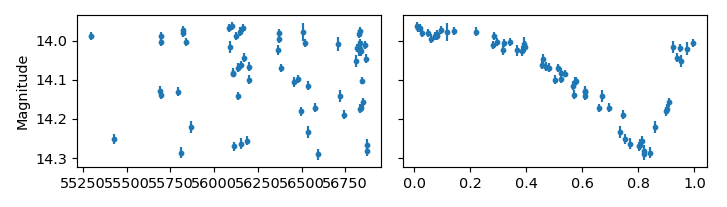

(62,)


In [2]:
lc_data = np.loadtxt('./data/rrl.dat').astype('float32')
time, mag, err, flag = lc_data.T
fig, ax = plt.subplots(1, 2, figsize=(7, 2), tight_layout=True, sharey=True)
ax[0].errorbar(time, mag, err, fmt='.');
P = 0.51194099999999998
phi = np.mod(time, P)/P
ax[1].errorbar(phi, mag, err, fmt='.');
ax[0].invert_yaxis()
ax[0].set_ylabel('Magnitude');

print(time.shape)

This is called a **light curve**: a time series of stellar brightness

This particular light curve corresponds to an RR Lyrae star

These stars pulsate regularly. The period of this one is 0.512 days

The plot on the left is actual light curve. The plot on the right is phase diagram

The phase diagram is obtained by "folding" the light curve with its given period

> The phase diagram shows the behavior of the star over one cycle

### Activity

Perform a Gaussian process regression over the folded light curve

- Select an appropiate kernel (or kernels) and priors for the parameters
- Fit the model and predict on `torch.linspace(0, 1, 100)`
- Sample 10 folded light curves from the GP and plot them

In [3]:
from sklearn.preprocessing import normalize

# data to torch tensor
time_torch = torch.from_numpy(time.astype("float32"))
phi_torch = torch.from_numpy(phi.astype("float32"))
brightness_torch = torch.from_numpy(mag.astype("float32"))
# brightness_torch = torch.from_numpy(normalize(mag.reshape(1, -1)).astype("float32"))

<IPython.core.display.Javascript object>


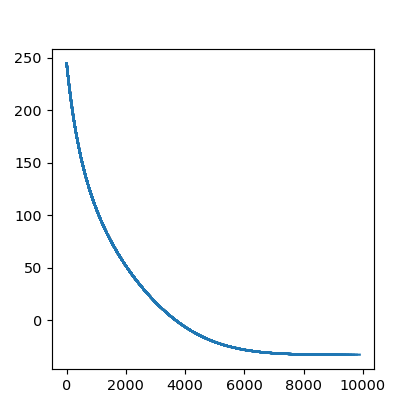

In [4]:
import pyro 
import pyro.contrib.gp as gp
from tqdm import tqdm_notebook
from pyro.distributions import LogNormal


pyro.clear_param_store()

# kernel
kernel_1 = gp.kernels.Matern52(input_dim = 1,
                            variance = torch.tensor(1.0),
                            lengthscale = torch.tensor(1.)
                              )

# kernel_2 = gp.kernels.RBF(input_dim = 1,
#                             variance = torch.tensor(1.0),
#                             lengthscale = torch.tensor(0.1)
#                               )
# combining kernels
kernel = kernel_1
# kernel = gp.kernels.Product(kernel_1, kernel_2)

# model
gpr_model = gp.models.GPRegression(phi_torch,
                                  brightness_torch,
                                  kernel = kernel,
#                                   jitter = 1e-6,
                                   jitter = 1e-2,
                                  noise = torch.tensor(1.)
                                  )

# priors to covariance parameters
gpr_model.kernel.lengthscale = pyro.nn.PyroSample(LogNormal(0., 1.0))
gpr_model.kernel.variance = pyro.nn.PyroSample(LogNormal(0., 1.0))
gpr_model.noise = pyro.nn.PyroSample(LogNormal(0., 1.0))

# optimizer 
optimizer = torch.optim.Adam(gpr_model.parameters(), lr = 1e-3)

# criterion
criterion = pyro.infer.Trace_ELBO().differentiable_loss


# training
num_epochs = 10000
fig, ax = plt.subplots(figsize = (4,4))

# epoch array
epoch_loss = np.zeros((num_epochs,))

# training by epochs
for epoch in tqdm_notebook(range(num_epochs)):
    
    # to zero all gradients
    optimizer.zero_grad()
    
    # getting loss value
    loss = criterion(gpr_model.model, gpr_model.guide)
    
    # get gradient
    loss.backward()
    
    # update parameters
    optimizer.step()
    
    # store epoch
    epoch_loss[epoch] = loss
#     print("iter {0}: {1}".format(epoch, loss))

    # plot errors
    if epoch % 100 == 0:
        
        ax.plot(range(epoch), epoch_loss[0:epoch], c = "tab:blue")
        fig.canvas.draw()

In [6]:
# Learned parameters
display("Covariance variance: ", gpr_model.kernel.variance.item())
display("covariance lengthscale: ", gpr_model.kernel.lengthscale.item())
display("model noise: ", gpr_model.noise.item())

'Covariance variance: '

0.33546486496925354

'covariance lengthscale: '

0.42261773347854614

'model noise: '

1.3739850521087646

data:  (62,)
mu:  torch.Size([100])
cov:  torch.Size([100, 100])


<IPython.core.display.Javascript object>


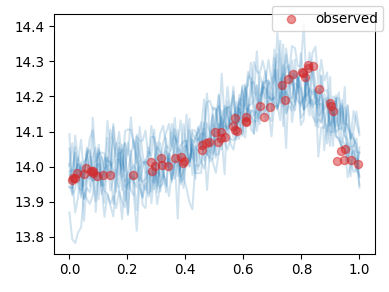

torch.Size([62])


In [31]:
# Plotting results
# time_for_predict = torch.linspace(0, 1, 10) # this is working
time_for_predict = torch.linspace(0, 1, 100) # this is working
# time_for_predict = time_torch

# print(time_for_predict.shape)
# mu, cov = gpr_model.forward(torch.from_numpy(phi.astype('float32')), full_cov=True, noiseless=True)
# mu, cov = gpr_model.forward(time_for_predict, full_cov=True, noiseless=True) # this is working
mu, cov = gpr_model.forward(time_for_predict, full_cov=True, noiseless = False) 


print("data: ", phi.shape)
print("mu: ", mu.shape)
print("cov: ", cov.shape)

# sampling
sampling = pyro.distributions.MultivariateNormal(mu, covariance_matrix = cov).sample(sample_shape = (10, ))
# print(sampling.shape)
# plotting
fig, ax = plt.subplots(figsize = (4,3), tight_layout = True)
for i in range(sampling.shape[0]):
    
#     print(time_for_predict.shape)
#     print(sampling[i, :].reshape(-1).shape)
    ax.plot(time_for_predict, sampling[i, :].reshape(-1), c = "tab:blue", alpha = 0.2)
#     ax.scatter(x_s, sampling[i, :], c = "red", alpha = 0.3)

print(brightness_torch.shape)
ax.scatter(phi_torch, brightness_torch, c = "tab:red", label = "observed", zorder = 10, alpha = 0.5)

# ax.scatter(time_for_predict, brightness_torch, label = "observed", linewidth = 10, c = "black", zorder = 10)
# # ax.plot(x_s, f(x_s), c = "tab:red", label = "true function")
fig.legend()

Perform a Gaussian process regression over the actual light curve
- Use a periodic kernel and fix the period to the known value
- Fit the model and predict on `torch.linspace(55500, 57000, 100)`
- Sample 10 light curves from the GP and plot them folded over the period

<IPython.core.display.Javascript object>


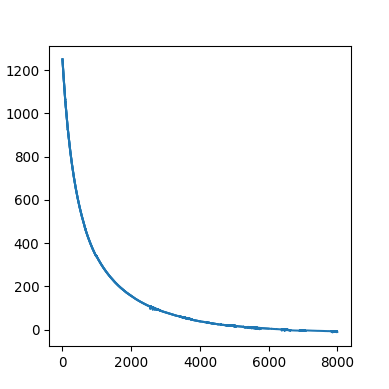

In [32]:
import pyro 
import pyro.contrib.gp as gp
from tqdm import tqdm_notebook
from pyro.distributions import LogNormal


pyro.clear_param_store()

# periodic kernel
kernel_1 = gp.kernels.Periodic(input_dim = 1,
                               variance = torch.tensor(1.0),
                               lengthscale = torch.tensor(1.),
                               period = torch.tensor(0.512) 
                              )

# kernel_2 = gp.kernels.RBF(input_dim = 1,
#                             variance = torch.tensor(1.0),
#                             lengthscale = torch.tensor(0.1)
#                               )
# combining kernels
kernel = kernel_1
# kernel = gp.kernels.Product(kernel_1, kernel_2)

# model
gpr_model = gp.models.GPRegression(time_torch,
                                  brightness_torch,
                                  kernel = kernel,
#                                   jitter = 1e-6,
                                   jitter = 1e-2,
                                  noise = torch.tensor(1.)
                                  )

# priors to covariance parameters
gpr_model.kernel.lengthscale = pyro.nn.PyroSample(LogNormal(0., 1.0))
gpr_model.kernel.variance = pyro.nn.PyroSample(LogNormal(0., 1.0))
gpr_model.noise = pyro.nn.PyroSample(LogNormal(0., 1.0))

# optimizer 
optimizer = torch.optim.Adam(gpr_model.parameters(), lr = 1e-3)

# criterion
criterion = pyro.infer.Trace_ELBO().differentiable_loss


# training
num_epochs = 10000
fig, ax = plt.subplots(figsize = (4,4))

# epoch array
epoch_loss = np.zeros((num_epochs,))

# training by epochs
for epoch in tqdm_notebook(range(num_epochs)):
    
    # to zero all gradients
    optimizer.zero_grad()
    
    # getting loss value
    loss = criterion(gpr_model.model, gpr_model.guide)
    
    # get gradient
    loss.backward()
    
    # update parameters
    optimizer.step()
    
    # store epoch
    epoch_loss[epoch] = loss
#     print("iter {0}: {1}".format(epoch, loss))

    # plot errors
    if epoch % 2000 == 0:
        
        ax.plot(range(epoch), epoch_loss[0:epoch], c = "tab:blue")
        fig.canvas.draw()

In [33]:
# Learned parameters
display("Covariance variance: ", gpr_model.kernel.variance.item())
display("covariance lengthscale: ", gpr_model.kernel.lengthscale.item())
display("model noise: ", gpr_model.noise.item())
display("kernel period: ", gpr_model.kernel.period.item())

'Covariance variance: '

0.47999441623687744

'covariance lengthscale: '

0.4970163106918335

'model noise: '

1.7136585712432861

'kernel period: '

0.49821868538856506

In [42]:
# Plotting results
time_for_predict = torch.linspace(55500, 57000, 100)
# time_for_predict = time_torch

# print(time_for_predict.shape)
# mu, cov = gpr_model.forward(torch.from_numpy(phi.astype('float32')), full_cov=True, noiseless=True)
mu, cov = gpr_model.forward(time_for_predict, full_cov=True, noiseless=False)

print("data: ", phi.shape)
print("mu: ", mu.shape)
print("cov: ", cov.shape)

# sampling
sampling = pyro.distributions.MultivariateNormal(mu, covariance_matrix = cov).sample(sample_shape = (10, ))
print("sampling: ", sampling.shape)

# fold light curves
# np.mod(time, P)/P
# plotting
fig, ax = plt.subplots(figsize = (7,3), tight_layout = True)
for i in range(sampling.shape[0]):
    
#     print(time_for_predict.shape)
#     print(sampling[i, :].reshape(-1).shape)
#     ax.plot(time_for_predict, sampling[i, :].reshape(-1), c = "tab:blue", alpha = 0.1)
    ax.plot(phi_torch, sampling[i, :].reshape(-1), c = "tab:blue", alpha = 0.1)
#     ax.scatter(x_s, sampling[i, :], c = "red", alpha = 0.3)

# ax.scatter(time_torch, brightness_torch, c = "tab:red", label = "observed")
ax.scatter(phi_torch, brightness_torch, c = "tab:red", label = "observed")

# ax.scatter(time_for_predict, brightness_torch, label = "observed", linewidth = 10, c = "black", zorder = 10)
# # ax.plot(x_s, f(x_s), c = "tab:red", label = "true function")
fig.legend()

data:  (62,)
mu:  torch.Size([100])
cov:  torch.Size([100, 100])
sampling:  torch.Size([10, 100])


<IPython.core.display.Javascript object>

ValueError: x and y must have same first dimension, but have shapes torch.Size([62]) and torch.Size([100])